# Data analyse pour Biocéanor :

## Objectif : 

Prédire le pourcentage d'oxygène dissous dans l'eau dans les 6 prochaines heures à partir des 2 derniers jours(48h).

In [153]:
%matplotlib inline
import os

import tensorflow as tf
tf.random.set_seed(12345)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
idx = pd.IndexSlice

### Exploration du jeu de données fourni :


In [154]:
df = pd.read_csv('data_for_interview.csv')
df.columns

Index(['Unnamed: 0', 'Datetime', 'WaterTemperature', 'DissolvedOxygen',
       'device', 'site', 'weather_temperature', 'dewpoint', 'humidity',
       'windspeed', 'winddirection'],
      dtype='object')

Le jeu de données va être indexé sur les colonnes <b>site, device et Datetime</b> afin de pouvoir traiter les données de chaque sonde et peut être adapté la prédiction en fonction du site. La colonne correspondant au numéro de ligne est supprimée (à voir si c'est une bonne idée ...).

In [155]:
df.Datetime = pd.to_datetime(df.Datetime, infer_datetime_format= True)
df.set_index(['site','device','Datetime'], inplace=True)
df.sort_index(inplace = True)
df.drop('Unnamed: 0',axis = 1, inplace = True)

Quand est il du type de données et des données manquantes ?

In [156]:
df.info()
print(df.describe())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1099 entries, ('site A', 'device 1', Timestamp('2020-06-15 09:00:00')) to ('site B', 'device 5', Timestamp('2020-06-26 05:00:00'))
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   WaterTemperature     1099 non-null   float64
 1   DissolvedOxygen      1096 non-null   float64
 2   weather_temperature  1099 non-null   float64
 3   dewpoint             1099 non-null   float64
 4   humidity             1099 non-null   int64  
 5   windspeed            1099 non-null   float64
 6   winddirection        1099 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 66.5+ KB
       WaterTemperature  DissolvedOxygen  weather_temperature     dewpoint  \
count       1099.000000      1096.000000          1099.000000  1099.000000   
mean          18.344054        88.673215            22.911738    13.042493   
std            1.789778        13.885082           

WaterTemperature       0
DissolvedOxygen        3
weather_temperature    0
dewpoint               0
humidity               0
windspeed              0
winddirection          0
dtype: int64

Les températures sont en °C (WaterTemp, weatherTemp et Dewpoint). L'oxygène dissous et l'humidité en %. La vitesse du vent est en km/h. La direction du vent est donnée en degré.

In [157]:
missing = df.DissolvedOxygen.isnull()
df.loc[missing,]

WaterTemperature  DissolvedOxygen  \
site   device   Datetime                                                 
site A device 1 2020-06-15 12:00:00             22.91              NaN   
                2020-06-15 16:00:00             23.47              NaN   
                2020-06-15 18:00:00             23.47              NaN   

                                     weather_temperature  dewpoint  humidity  \
site   device   Datetime                                                       
site A device 1 2020-06-15 12:00:00                 26.1      11.4        40   
                2020-06-15 16:00:00                 27.0       9.8        34   
                2020-06-15 18:00:00                 26.3      11.2        39   

                                     windspeed  winddirection  
site   device   Datetime                                       
site A device 1 2020-06-15 12:00:00       37.0            310  
                2020-06-15 16:00:00       33.3            308  
                2020-06-15 18:00:00       22.0            330

In [158]:
df.loc[idx['site A','device 1','2020-06-15':'2020-06-17'],:]

WaterTemperature  DissolvedOxygen  \
site   device   Datetime                                                 
site A device 1 2020-06-15 09:00:00         22.810000        98.200000   
                2020-06-15 11:00:00         22.910000        98.460000   
                2020-06-15 12:00:00         22.910000              NaN   
                2020-06-15 14:00:00         23.365000       101.585000   
                2020-06-15 16:00:00         23.470000              NaN   
                2020-06-15 18:00:00         23.470000              NaN   
                2020-06-17 12:00:00         16.823333        72.373333   
                2020-06-17 13:00:00         16.830000        77.053333   
                2020-06-17 14:00:00         16.843333        80.093333   
                2020-06-17 15:00:00         16.836667        86.383333   
                2020-06-17 16:00:00         16.833333        93.316667   
                2020-06-17 17:00:00         16.830000        98.345000   
                2020-06-17 18:00:00         16.820000        99.416667   
                2020-06-17 19:00:00         16.813333        98.490000   
                2020-06-17 20:00:00         16.750000        96.763333   
                2020-06-17 21:00:00         16.673333        94.096667   
                2020-06-17 22:00:00         16.563333        94.276667   
                2020-06-17 23:00:00         16.530000        91.435000   

                                     weather_temperature  dewpoint  humidity  \
site   device   Datetime                                                       
site A device 1 2020-06-15 09:00:00                 23.2      11.9        49   
                2020-06-15 11:00:00                 26.0      12.1        42   
                2020-06-15 12:00:00                 26.1      11.4        40   
                2020-06-15 14:00:00                 27.0       9.8        34   
                2020-06-15 16:00:00                 27.0       9.8        34   
                2020-06-15 18:00:00                 26.3      11.2        39   
                2020-06-17 12:00:00                 24.9      11.1        42   
                2020-06-17 13:00:00                 25.0      11.9        44   
                2020-06-17 14:00:00                 25.0      11.9        44   
                2020-06-17 15:00:00                 23.9      10.9        44   
                2020-06-17 16:00:00                 23.0      11.1        47   
                2020-06-17 17:00:00                 23.0      12.0        50   
                2020-06-17 18:00:00                 22.4      12.4        53   
                2020-06-17 19:00:00                 20.0      15.0        73   
                2020-06-17 20:00:00                 20.0      15.0        73   
                2020-06-17 21:00:00                 19.1      15.0        77   
                2020-06-17 22:00:00                 19.0      15.1        78   
                2020-06-17 23:00:00                 19.0      12.0        64   

                                     windspeed  winddirection  
site   device   Datetime                                       
site A device 1 2020-06-15 09:00:00       41.0            300  
                2020-06-15 11:00:00       38.9            309  
                2020-06-15 12:00:00       37.0            310  
                2020-06-15 14:00:00       37.0            307  
                2020-06-15 16:00:00       33.3            308  
                2020-06-15 18:00:00       22.0            330  
                2020-06-17 12:00:00       22.0            270  
                2020-06-17 13:00:00       25.9            273  
                2020-06-17 14:00:00       25.9            265  
                2020-06-17 15:00:00       35.0            240  
                2020-06-17 16:00:00       25.9            242  
                2020-06-17 17:00:00       25.9            244  
                2020-06-17 18:00:00       39.0            2

Les données manquantes sont présentes sur la sonde 1 du site A. Ces données manquantes précèdent la journée du 16 juin 2020 où la sonde 1 n'a rien enregistré. L'enregistrement n'a redémarré qu'à midi le 17 juin.
D'autre part, nous voyons que les données sont enregistrées toutes les heures.

Il faut voir maintenant si chaque sonde reçoit bien un enregistrement toutes les heures. Pour rappel, on souhaite avoir 48h d'enregistrement pour prédire les 6 heures suivantes.


In [159]:
df.reset_index(['site','device']).groupby(['site','device']).resample('D').count()

site  device  WaterTemperature  DissolvedOxygen  \
site   device   Datetime                                                      
site A device 1 2020-06-15     6       6                 6                3   
                2020-06-16     0       0                 0                0   
                2020-06-17    12      12                12               12   
                2020-06-18    24      24                24               24   
                2020-06-19    24      24                24               24   
                2020-06-20    24      24                24               24   
                2020-06-21    24      24                24               24   
                2020-06-22    24      24                24               24   
                2020-06-23    24      24                24               24   
                2020-06-24    24      24                24               24   
                2020-06-25    24      24                24               24   
                2020-06-26     6       6                 6                6   
       device 2 2020-06-17    13      13                13               13   
                2020-06-18    24      24                24               24   
                2020-06-19    24      24                24               24   
                2020-06-20    24      24                24               24   
                2020-06-21    24      24                24               24   
                2020-06-22    24      24                24               24   
                2020-06-23    24      24                24               24   
                2020-06-24    24      24                24               24   
                2020-06-25    24      24                24               24   
                2020-06-26     6       6                 6                6   
site B device 3 2020-06-16     9       9                 9                9   
                2020-06-17    24      24                24               24   
                2020-06-18    21      21                21               21   
                2020-06-19    23      23                23               23   
                2020-06-20    24      24                24               24   
                2020-06-21    22      22                22               22   
                2020-06-22    23      23                23               23   
                2020-06-23    24      24                24               24   
                2020-06-24    24      24                24               24   
                2020-06-25    20      20                20               20   
                2020-06-26     6       6                 6                6   
       device 4 2020-06-16    11      11                11               11   
                2020-06-17    24      24                24               24   
                2020-06-18    22      22                22               22   
                2020-06-19    24      24                24               24   
                2020-06-20    24      24                24               24   
                2020-06-21    23      23                23               23   
                2020-06-22    23      23                23               23   
                2020-06-23    24      24                24               24   
                2020-06-24    24      24                24               24   
                2020-06-25    22      22                22               22   
                2020-06-26     6       6                 6                6   
       device 5 2020-06-16    13      13                13               13   
                2020-06-17    24      24                24               24   
                2020-06-18    21      21                21               21   
                2020-06-19    24      24                24               24   
                2020-06-20    24      24                24               24   

Il y a des trous dans l'enregistrement de chaque sonde. Nous pouvons tout de même recupérer suffisamment de périodes de 48h pour constituer des jeux d'entrainement. 
Je pourrai faire un resample pour avoir tous les enregistrements à chaque heure mais cela va créer des NaN. Une fois le modèle de prédiction ajusté, je pourrai envisager de prédire les enregistrements manquant et faire un nouvel apprentissage du modèle.

Un jeu d'entrainement doit alors contenir 48 observations successives pour prédire les 6 prochaines !
Dans un premier temps :
Je vais travailler sur les sondes 1 et 2 du site A sur la période du 18 au 25 juin.

In [160]:
data = df.reset_index()
data = data[data.device.isin(['device 1','device 2'])]
data.set_index('Datetime',inplace = True)
data = data.loc['2020-06-18':'2020-06-25']
data.head()

,site,device,WaterTemperature,DissolvedOxygen,weather_temperature,dewpoint,humidity,windspeed,winddirection
Datetime,,,,,,,,,
2020-06-18 00:00:00,site A,device 1,16.490000,90.933333,18.1,11.4,65,15.0,310
2020-06-18 01:00:00,site A,device 1,16.463333,89.803333,18.0,11.1,64,14.8,267
2020-06-18 02:00:00,site A,device 1,16.466667,81.803333,17.0,11.1,68,13.0,272
2020-06-18 03:00:00,site A,device 1,16.446667,79.136667,16.1,10.8,71,9.0,300
2020-06-18 04:00:00,site A,device 1,16.470000,75.226667,15.0,11.0,77,9.3,294


(15.0, 20.0)

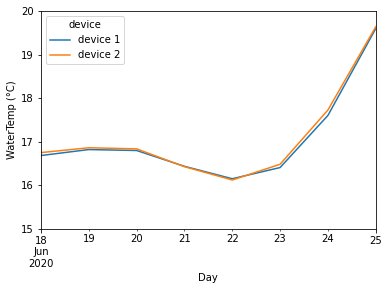

In [161]:
data.groupby('device').resample('D').mean().unstack('device').WaterTemperature.plot()
plt.xlabel('Day')
plt.ylabel('WaterTemp (°C)')
plt.ylim([15,20])

Text(0, 0.5, 'AirTemp (°C)')

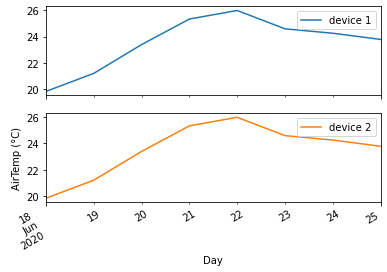

In [162]:
data.groupby('device').resample('D').mean().unstack('device').weather_temperature.plot(subplots=True)
plt.xlabel('Day')
plt.ylabel('AirTemp (°C)')

Text(0, 0.5, 'Dewpoint (°C)')

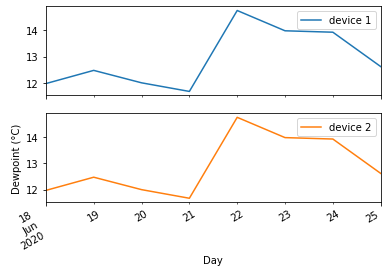

In [163]:
data.groupby('device').resample('D').mean().unstack('device').dewpoint.plot(subplots=True)
plt.xlabel('Day')
plt.ylabel('Dewpoint (°C)')

Les deux sondes ont des enregistrements réellement similaires. 

Je crée une nouvelle variable qui me donne la direction cardinale du vent.

In [164]:
data['CardWind'] = pd.cut(data.winddirection,bins=[0,45,135,225,315,360] , labels=['N','E','S','O','No'])
data.CardWind.replace('No','N',inplace = True)
print(data.groupby(['device']).CardWind.value_counts())

device    CardWind
device 1  O           97
          S           49
          N           35
          E           11
device 2  O           97
          S           49
          N           35
          E           11
Name: CardWind, dtype: int64


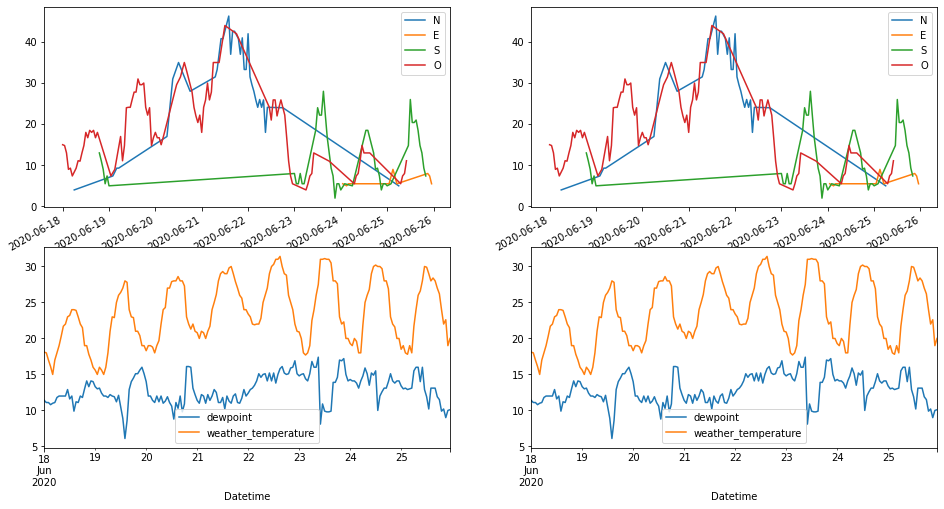

In [165]:
fig,ax = plt.subplots(2,2)
data[data['device']=='device 1'].groupby('CardWind').windspeed.plot(legend=True,figsize=[16,9],ax=ax[0,0])
data[data['device']=='device 1'].dewpoint.plot(legend=True,figsize=[16,9],ax=ax[1,0])
data[data['device']=='device 1'].weather_temperature.plot(legend=True,figsize=[16,9],ax=ax[1,0])
data[data['device']=='device 2'].groupby('CardWind').windspeed.plot(legend=True,figsize=[16,9],ax=ax[0,1])
data[data['device']=='device 2'].dewpoint.plot(legend=True,figsize=[16,9],ax=ax[1,1])
data[data['device']=='device 2'].weather_temperature.plot(legend=True,figsize=[16,9],ax=ax[1,1])

Je rajoute aussi un rythme circadien pour les fluctuations jour/nuit.

In [166]:
def get_part_of_day(hour):
    return (
        "morning" if 6 <= hour <= 10
        else
        "afternoon" if 11 <= hour <= 15
        else
        "evening" if 16 <= hour <= 20
        else
        "night"
    )

In [167]:
data['PartofDay']= [get_part_of_day(hour) for hour in data.index.hour]
data.head()

,site,device,WaterTemperature,DissolvedOxygen,weather_temperature,dewpoint,humidity,windspeed,winddirection,CardWind,PartofDay
Datetime,,,,,,,,,,,
2020-06-18 00:00:00,site A,device 1,16.490000,90.933333,18.1,11.4,65,15.0,310,O,night
2020-06-18 01:00:00,site A,device 1,16.463333,89.803333,18.0,11.1,64,14.8,267,O,night
2020-06-18 02:00:00,site A,device 1,16.466667,81.803333,17.0,11.1,68,13.0,272,O,night
2020-06-18 03:00:00,site A,device 1,16.446667,79.136667,16.1,10.8,71,9.0,300,O,night
2020-06-18 04:00:00,site A,device 1,16.470000,75.226667,15.0,11.0,77,9.3,294,O,night


### Prédiction de l'oxygène dissous au site A
### 1ere Methode : Multistep Model for Prevision Time Serie

https://www.tensorflow.org/tutorials/structured_data/time_series#part_1_forecast_a_univariate_time_series

On souhaite prédire l'oxygène dissous en observant les 48h précédentes et en estimant les 6h prochaines. Je vais utiliser la température de l'eau, de l'air et les caractéristiques du vent.

In [168]:
features_considered = ['WaterTemperature', 'DissolvedOxygen','weather_temperature','windspeed','winddirection']
features = data[features_considered]
features.index = data.index
features.sort_index()
features.head()

,WaterTemperature,DissolvedOxygen,weather_temperature,windspeed,winddirection
Datetime,,,,,
2020-06-18 00:00:00,16.490000,90.933333,18.1,15.0,310
2020-06-18 01:00:00,16.463333,89.803333,18.0,14.8,267
2020-06-18 02:00:00,16.466667,81.803333,17.0,13.0,272
2020-06-18 03:00:00,16.446667,79.136667,16.1,9.0,300
2020-06-18 04:00:00,16.470000,75.226667,15.0,9.3,294


Le modèle prend en entrée des np.array donc je convertis mes valeurs. Puis je fixe un pourcentage pour séparer mon jeu en training et test. Les données doivent également être normalisées.

In [169]:
dataset = features.values

num_data = len(dataset)
train_split = 0.8
num_train = int(train_split * num_data)
num_test = num_data - num_train

x_scaler = MinMaxScaler()
dataset = x_scaler.fit_transform(dataset)


#data_mean = dataset[:num_train].mean(axis=0)
#data_std = dataset[:num_train].std(axis=0)
#dataset = (dataset-data_mean)/data_std

La fonction ci dessous permet de séparer notre jeu de données. Elle implique les différentes colonnes de paramètres que l'on a choisi.

In [170]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)


On définit la fenêtre d'apprentissage basée sur les 48h précédentes et la prédiction des 6h prochaines. 
Je me demande si le faire d'avoir mis les sondes 1 et 2 ensemble "dédoublent" chaque enregistrement ou si l'indexation sur 'Datetime' est utilisée pour se décaler dans le temps.

In [171]:
past_history = 48
future_target = 6
STEP = 1


x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 num_train, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             num_train, None, past_history,
                                             future_target, STEP)


In [172]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('Target Dissolve Oxygen to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (48, 5)
Target Dissolve Oxygen to predict : (6,)


Nous allons prendre 300 enregistrements par lot de 48 pour faire l'entrainement du modèle.

In [173]:
BATCH_SIZE = 300
BUFFER_SIZE = 48

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()


In [174]:
def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()


Visualisons 3 passages dans le modèle de prédiction de l'oxygène dissous !

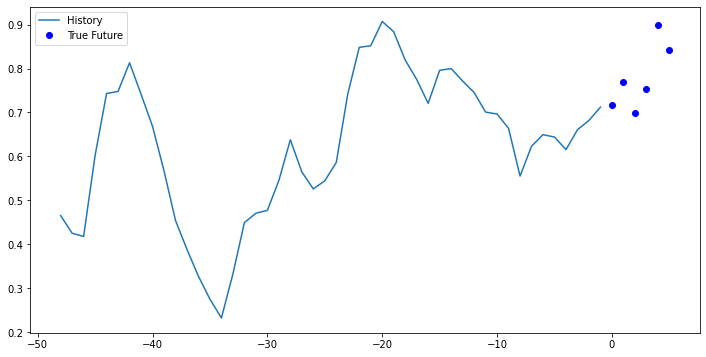

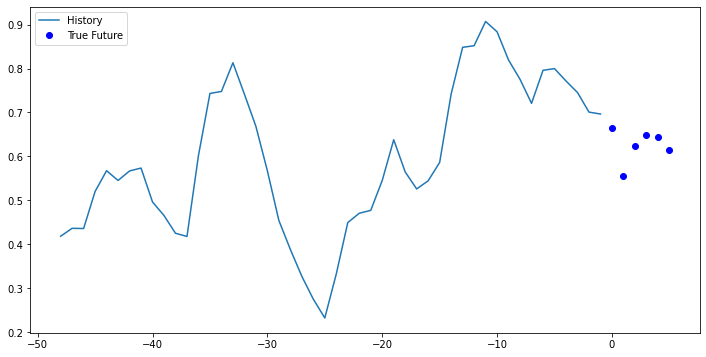

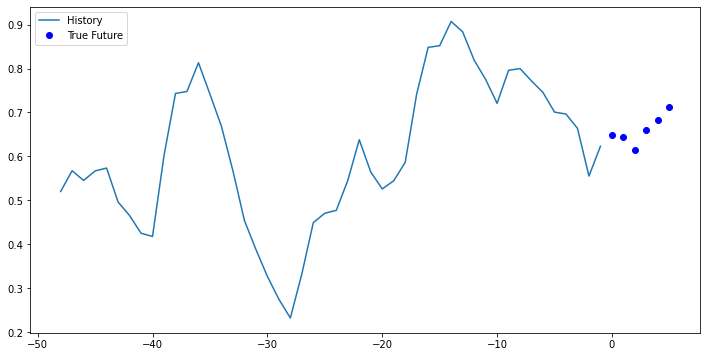

In [175]:
for x, y in train_data_multi.take(3):
  multi_step_plot(x[0], y[0], np.array([0]))


MultiStep Model :

In [176]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(48,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(24, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(6))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


In [177]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(23, 6)


In [178]:
EVALUATION_INTERVAL = 100
EPOCHS = 20

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/20
100/100 [==============================] - 12s 120ms/step - loss: 0.1407 - val_loss: 0.0736
Epoch 2/20
100/100 [==============================] - 12s 120ms/step - loss: 0.0856 - val_loss: 0.1054
Epoch 3/20
100/100 [==============================] - 12s 118ms/step - loss: 0.0657 - val_loss: 0.0829
Epoch 4/20
100/100 [==============================] - 13s 126ms/step - loss: 0.0567 - val_loss: 0.0824
Epoch 5/20
100/100 [==============================] - 11s 115ms/step - loss: 0.0522 - val_loss: 0.0946
Epoch 6/20
100/100 [==============================] - 12s 123ms/step - loss: 0.0488 - val_loss: 0.1064
Epoch 7/20
100/100 [==============================] - 12s 116ms/step - loss: 0.0461 - val_loss: 0.1410
Epoch 8/20
100/100 [==============================] - 12s 124ms/step - loss: 0.0439 - val_loss: 0.1299
Epoch 9/20
100/100 [==============================] - 12s 121ms/step - loss: 0.0424 - val_loss: 0.1391
Epoch 10/20
100/100 [==============================] - 12s 119ms/step - l

In [179]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


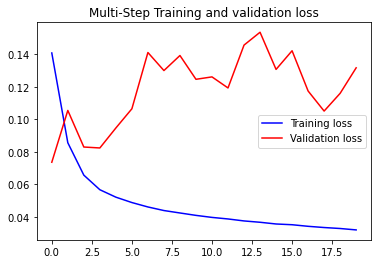

In [180]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

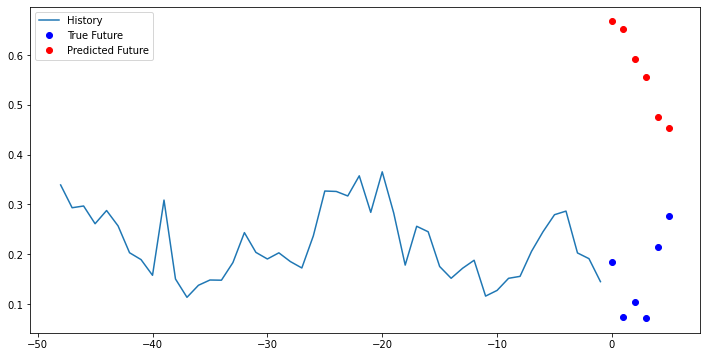

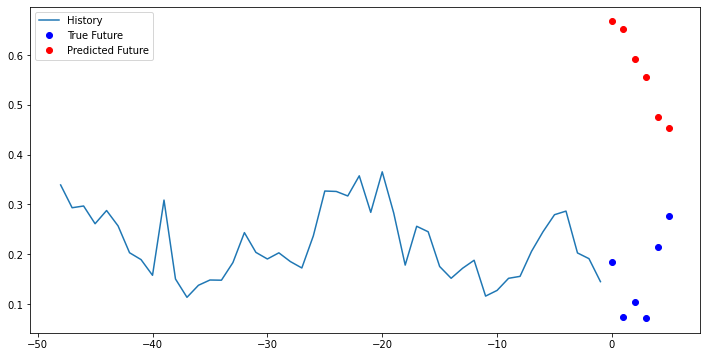

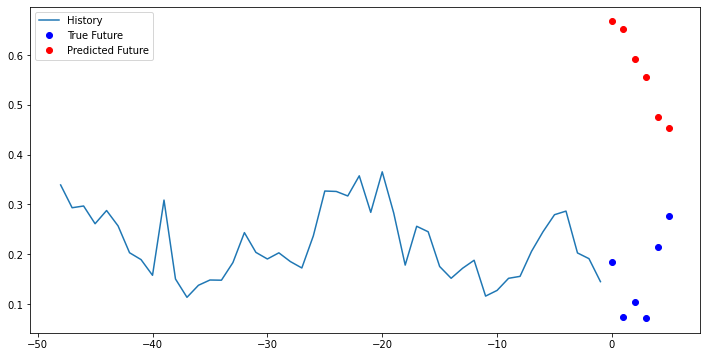

In [181]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Malgrè plusieurs essais, les prédictions obtenues avec cette méthode s'éloignent trop de la réalité. Je décide de tester une autre méthode.

### 2eme Methode Recurrent Neural Network

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb


A partir du jeu de donnée sur le site A, je recupère les valeurs qui alimenteront le modèle.

In [182]:
target_names = ['DissolvedOxygen','weather_temperature','WaterTemperature','dewpoint','windspeed']
shift_hours = 6

Je crée un jeu de données décalé dans le temps.

In [183]:
df_targets = data[target_names].shift(-shift_hours)
df_targets.tail()

,DissolvedOxygen,weather_temperature,WaterTemperature,dewpoint,windspeed
Datetime,,,,,
2020-06-25 19:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-25 20:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-25 21:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-25 22:00:00,NaN,NaN,NaN,NaN,NaN
2020-06-25 23:00:00,NaN,NaN,NaN,NaN,NaN


In [184]:
x_data = data.drop(['site','device','CardWind','PartofDay'],axis=1).values[:-shift_hours]
y_data = df_targets.values[:-shift_hours]

In [185]:
print("Shape input:", x_data.shape)
print("Shape output:", y_data.shape)

Shape input: (378, 7)
Shape output: (378, 5)


Je sépare mes données en training et test. Je coupe à 80:20.

In [186]:
num_data = len(x_data)
train_split = 0.8
num_train = int(train_split * num_data)
num_test = num_data - num_train

x_train = x_data[:num_train]
x_test = x_data[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]

In [187]:
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]
print('Inputs Signals: {}, Outputs Signals: {}'.format(num_x_signals,num_y_signals))

Inputs Signals: 7, Outputs Signals: 5


Mise à l'échelle des données.

In [188]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Generateur de données

In [189]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [190]:
batch_size = 300
sequence_length = 96

In [191]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [192]:
x_batch, y_batch = next(generator)

In [193]:
print(x_batch.shape)
print(y_batch.shape)

(300, 96, 7)
(300, 96, 5)


Validation du modèle

In [194]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

Recurrent Neural Network

In [195]:
model = Sequential()
model.add(GRU(units=48,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

Loss Function

In [196]:
warmup_steps = 48

In [197]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

Compilation du modèle

In [198]:
optimizer = RMSprop(lr=1e-2)

In [199]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 48)          8208      
_________________________________________________________________
dense_6 (Dense)              (None, None, 5)           245       
Total params: 8,453
Trainable params: 8,453
Non-trainable params: 0
_________________________________________________________________


Callback Functions : checkpoint

In [200]:
path_checkpoint = 'do_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [201]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [202]:
callback_tensorboard = TensorBoard(log_dir='./do_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [203]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [204]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

Education du modèle

In [205]:
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0217
Epoch 00001: val_loss improved from inf to 0.03756, saving model to do_checkpoint.keras
100/100 [==============================] - 17s 171ms/step - loss: 0.0217 - val_loss: 0.0376 - lr: 0.0100
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0076
Epoch 00002: val_loss did not improve from 0.03756

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
100/100 [==============================] - 16s 159ms/step - loss: 0.0076 - val_loss: 0.0444 - lr: 0.0100
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00003: val_loss did not improve from 0.03756

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 16s 159ms/step - loss: 0.0032 - val_loss: 0.0496 - lr: 1.0000e-03
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0025
Epoch 00004: val_loss did not improv

In [206]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Performance du Modèle :

In [207]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 0s/step - loss: 0.0376


In [208]:
print("loss (test-set):", result)

loss (test-set): 0.03755653277039528


Prédicition du modèle :

In [209]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

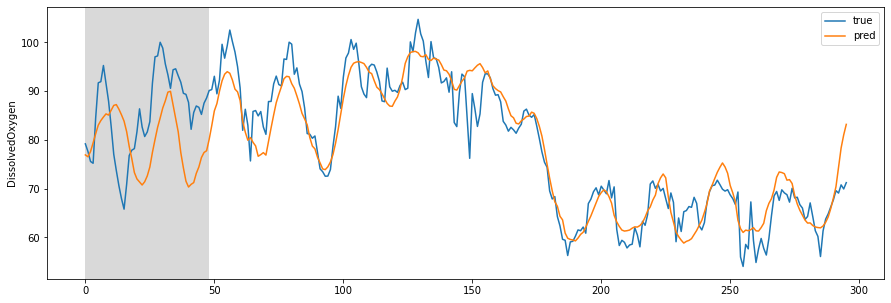

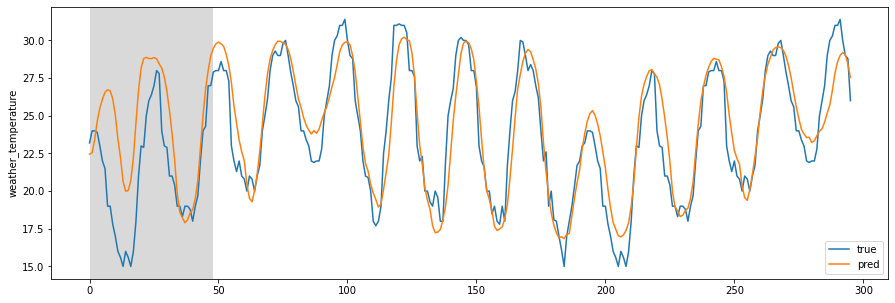

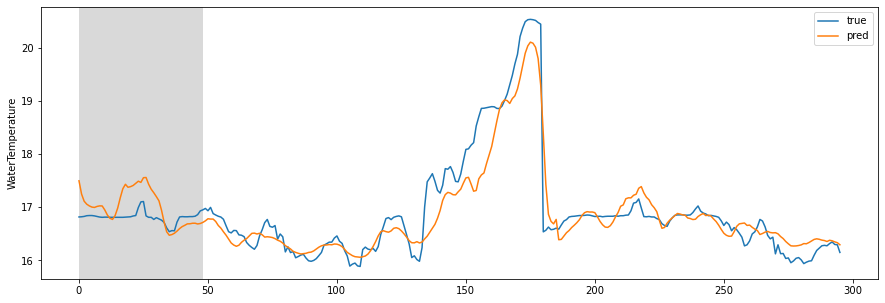

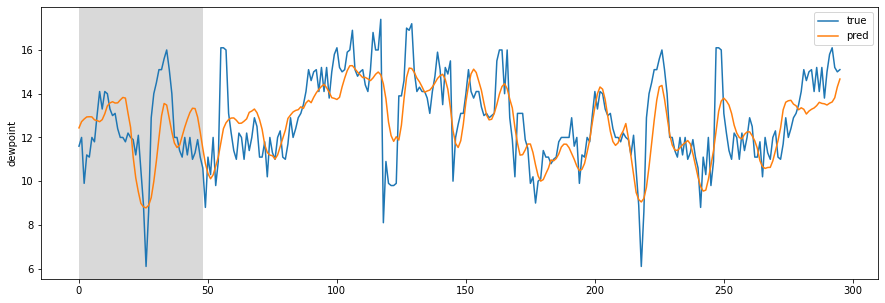

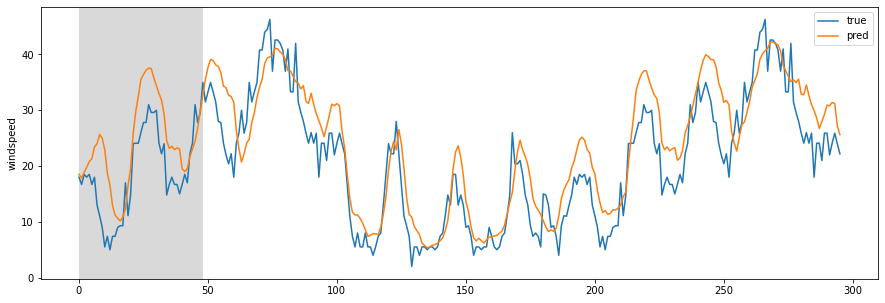

In [210]:
plot_comparison(start_idx=6, length=300, train=True)

Cette seconde méthode m'apparait plus confortable à manipuler. Les résultats montrent une prédiction statisfaisante de l'oxygène dissous en fonction des paramètres WaterTemp, weatherTemp, point de rosée, vitesse du vent.

J'aurai aimé intégrer le moment de la journée car les fluctuations de la température de l'air y sont directement liées. 
Sur les premiers graphes, on pouvait voir que le vent du nord et de l'ouest prédominés sur le site A. Il serait intéressant d'intégrer également la direction du vent (N,O,S,E).

On aurait pu s'intéresser au pourcentage de variation d'une heure à l'autre et basé le modèle sur cela.


In [211]:
df['WTempshifted'] = df.WaterTemperature.shift(periods = 1)
df['WTemp_pctchange'] = df.WaterTemperature.pct_change().mul(100)

In [212]:
df['DOshifted'] = df.DissolvedOxygen.shift(periods = 1)
df['DO_pctchange'] = df.DissolvedOxygen.pct_change().mul(100)

In [213]:
df['Tempshifted'] = df.weather_temperature.shift(periods = 1)
df['Temp_pctchange'] = df.weather_temperature.pct_change().mul(100)